![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

## **MASTER DATA SCIENCE:** Nuclio
## **PROFESORES:** Valentina Borgonovi, Isidre Royo
## **ENTREGABLE 4:** Deep Learning - Visión por computador
## **ALUMNO:** Simone Solieri


## **Proyecto 3** - Resumen
**Objetivo:** Optimizar la arquitectura de la red neuronal para subir la accuracy de validation y hacer el modelo mas robusto. En principio tengo un modelo que no es muy estable, sobre todo el error den validación. Como la red tiene 8 capas con funciones de activacion, el problema podría ser que los valores de salida de esas capas se esten disparando a causa del aplicación de las funciones de activación. Por ese motivo, la red podría beneficiar de la batch normalization, para estabilizar y hacer más rapido el entrenamiento preparando el terreno para la succesiva aplicación del dropout (que lo que hace es introducir aun mas ruido.) Para ver los beneficios aportados por la batch normalization, en este experimento decido de aplicar el droput en el experimento siguiente.

**Cambios efectuados:**
- batch normalization despues de cada capa con función de activación

 **Resultados**:
Resultados esperados: mejora del modelo

Resultados obtenidos: Gran estabilización del entrenamiento, con curvas mucho más regulares. La accuracy de test baja de pocos decimos, pero evidentemente los beneficios aportados al entrenamiento en terminos de estabilización son muy relevantes y un modelo más estable es un mejor punto de partida para el dropout, para que funcione mejor. Por eso me quedo con esta arquitectura.


## 1. Librerias & Google Drive

Para empezar carguemos esas librerias que nos hacen falta

In [ ]:
from tensorflow import keras as ks
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from matplotlib import pyplot as plt
import numpy as np
import time
import datetime

Incorporamos la carpeta de Google Drive para poder "guardar" nuestros modelos

1. Abrir barra lateral de Carpeta
2.  Hacer click en carpeta con logo de Google Drive


In [ ]:
# Aquí iria el codigo para conectarse a Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Arquitectura de red del modelo


In [ ]:
model = ks.Sequential()

model.add(ks.layers.Conv2D(32, (3, 3), strides=1,
          activation='relu',padding='same',
          input_shape=(32,32,3)))
model.add(ks.layers.BatchNormalization())

model.add(ks.layers.Conv2D(32, (3, 3), strides=1,
          activation='relu',padding='same'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Conv2D(64, (3, 3), strides=1,
          activation='relu',padding='same'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Conv2D(64, (3, 3), strides=1,
          activation='relu',padding='same'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Conv2D(128, (3, 3), strides=1,
          activation='relu',padding='same'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Conv2D(128, (3, 3), strides=1,
          activation='relu',padding='same'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Conv2D(128, (3, 3), strides=1,
          activation='relu',padding='same'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.MaxPooling2D((2, 2)))

model.add(ks.layers.Flatten())
model.add(ks.layers.Dense(256, activation='relu'))
model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Dense(10, activation='softmax'))


Para revisar un modelo, nos basta con llamar al método **.summary()** del modelo

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                        

## 3. Optimizador, función error


In [ ]:
model.compile(optimizer= 'Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## 4. Preparamos los datos

Cargamos los datos de CIFAR10 de los datasets directamente de las librerias de Keras. Estos ya estan dispuestos en train and test

**Detalle importante:**
> La red neuronal requiere que los inputs sean números reales, y lo haremos forzando la division de los valores de dentro de las matrices 32x32 (que tienen valoress del 0 al 255) por 255.0 (un real)

In [ ]:
cifar10 = ks.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train_scaled, x_test_scaled = x_train / 255.0, x_test / 255.0

170498071/170498071 [==============================] - 3s 0us/step


In [ ]:
print("Etiquetas de train:", y_train)


# Convertir los datos en arrays de una dimension (vectores) es una buena mejora en el dataset
y_train = y_train.ravel()
y_test = y_test.ravel()


print("Etiquetas de train (en vector):", y_train)


Etiquetas de train: [[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]
Etiquetas de train (en vector): [6 9 9 ... 9 1 1]


Obtenemos un array con todas las labels de CIFAR10

In [ ]:
cifar10_labels = [
'airplane', # id 0
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck'
]

print('Number of labels: %s' % len(cifar10_labels))

Number of labels: 10


Pintemos una muestra de las imagenes del dataset CIFAR10, a ver si se parece en algo a lo que esperamos.
Primero, vemos que tipos de datos tengo, después mapeamos esas matrices en una escala de grises utilizando el método **.get_cmap()** de PlotLy con los nueve primeros números del dataset.

Train: X=(50000, 32, 32, 3), y=(50000,)
Test: X=(10000, 32, 32, 3), y=(10000,)


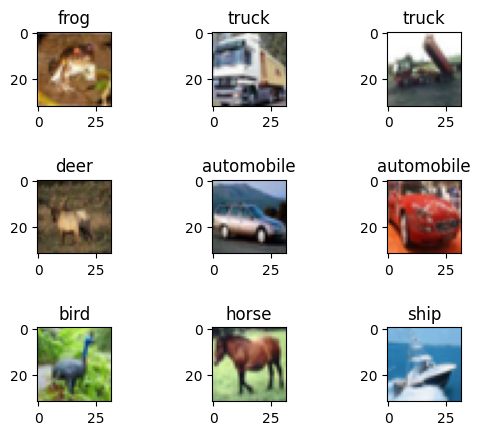

In [ ]:
# Pintemos una muestra de las las imagenes del dataset Cifar10

print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

for i in range(9):

    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title(cifar10_labels[y_train[i]])

plt.subplots_adjust(hspace = 1)
plt.show()

Como vamos a querer ir haciendo validación a la vez que entrenamos (muy practico)

In [ ]:
x_val_scaled = x_train_scaled[-10000:]
y_val = y_train[-10000:]

x_train_scaled = x_train_scaled[:-10000]
y_train = y_train[:-10000]


Cuando añadimos convoluciones, necesitamos "pre-tratar los datos", porque **la convolución espera una matriz de 4 campos** (más parecido a "imagenes"), en el caso de MNIST. CIFAR10 ya tiene el shape adecuado, así que no tenemos que hacer nada, pero como siempre decimos: es mejor que comprobeis su tamaño.

Por eso, al salir de la Convolution, hay que hacer un Flatten, porque las capas FullDense esperan arrays, no matrices!!

Luego lo imprimimos para ver que todo está correcto

In [ ]:
# Validamos el resultado
print('Train: X=%s, y=%s' % (x_train_scaled.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test_scaled.shape, y_test.shape))
print('Validation: X=%s, y=%s' % (x_val_scaled.shape, y_val.shape))

Train: X=(40000, 32, 32, 3), y=(40000,)
Test: X=(10000, 32, 32, 3), y=(10000,)
Validation: X=(10000, 32, 32, 3), y=(10000,)


## 5. Entrenamiento

Ya podemos ponernos a entrenar el modelo!! Ojo, que hemos de entrenar contra los datos convertidos al formato que espera la Convolution.

Empezaremos con 30 epocs, es decir, 30 pasadas completas del dataset (que a su vez sera con mini-batches internamente), fijando un batch de 512

El metodo .fit() nos permite, definir además si disponemos de varias CPUs, GPUs, y si queremos ir validando datos a cada fin de epoch.

In [ ]:
t = time.perf_counter()

In [ ]:
# Callbacks
earlystop_loss = EarlyStopping(monitor='loss', patience=10)
earlystop_acc = EarlyStopping(monitor='accuracy', patience=5)
reduce_lr_callback = ReduceLROnPlateau(monitor='loss',factor=0.1,patience=3, min_lr=0.0001)

# ModelCheckpoint
checkpoint_path = '/content/drive/MyDrive/Master_Data_Science/Entregables/Entregable_04-Deep_Learning/Models/Model_Checkpoints/Best_accuracy_proyecto_03'
modelcheckpoint_best_acc = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True)

In [ ]:
history = model.fit(x_train_scaled, y_train,
                    epochs=200,
                    batch_size= 512,
                    validation_data=(x_val_scaled, y_val),
                    callbacks=[modelcheckpoint_best_acc, reduce_lr_callback, earlystop_acc])

Epoch 1/200
79/79 [==============================] - 25s 159ms/step - loss: 1.3629 - accuracy: 0.5234 - val_loss: 2.9762 - val_accuracy: 0.1052 - lr: 0.0010
Epoch 2/200
79/79 [==============================] - 7s 93ms/step - loss: 0.8697 - accuracy: 0.6971 - val_loss: 3.1059 - val_accuracy: 0.1638 - lr: 0.0010
Epoch 3/200
79/79 [==============================] - 5s 59ms/step - loss: 0.6635 - accuracy: 0.7678 - val_loss: 3.7871 - val_accuracy: 0.1443 - lr: 0.0010
Epoch 4/200
79/79 [==============================] - 7s 91ms/step - loss: 0.5087 - accuracy: 0.8227 - val_loss: 2.5897 - val_accuracy: 0.2585 - lr: 0.0010
Epoch 5/200
79/79 [==============================] - 9s 108ms/step - loss: 0.3634 - accuracy: 0.8764 - val_loss: 2.0765 - val_accuracy: 0.3858 - lr: 0.0010
Epoch 6/200
79/79 [==============================] - 7s 90ms/step - loss: 0.2588 - accuracy: 0.9142 - val_loss: 1.4156 - val_accuracy: 0.5662 - lr: 0.0010
Epoch 7/200
79/79 [==============================] - 9s 109ms/step 

In [ ]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Tiempo de entrenamiento:', elapsed_time)

Tiempo de entrenamiento: 0:02:41.741210


Cargo el mejor model que he guardado con el ModelCheckpoint.


In [ ]:
model = ks.models.load_model(checkpoint_path)

## 6. Evaluamos los resultados

Obtengamos una grafica de como el error y la accuracy van evolucionando en cada epoch en los datos de entrenamiento y en la validación

In [ ]:
_, acc = model.evaluate(x_test_scaled, y_test, verbose=0)
print('> %.3f' % (acc * 100.0))

> 76.290


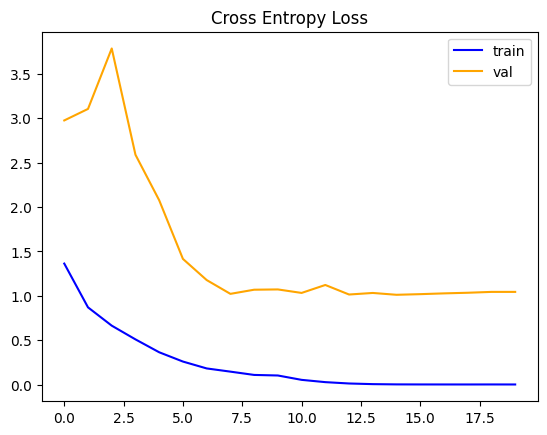

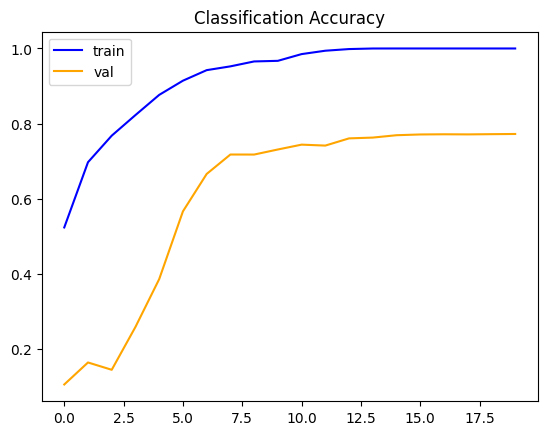

In [ ]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='val')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='val')
plt.legend()
plt.show()

Veamos que tipo de predicciones estoy obteniendo sobre el conjunto de test (vamos a pintar las imagenes y sus clasificaciones)

In [ ]:
predictions = model.predict(x_test)

313/313 [==============================] - 1s 3ms/step


Una de las ventajas de Python es que hay montones de funciones y código realizado por terceras personas. Aquí me he fusilado unas bonitas funciones (que he adaptado un poco a mis necesidades) para poder pintar las imagenes, su label (ground truth) y las clasificaciones que hemos realizado.

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Dibujamos las primeras imagenes, con las predicciones y sus valores reales (un total de 20 imagenes, para no abusar de vuestros laptops)

Coloreamos las prediciones correctas en azul y los fallos en rojo. Aunque primero he impreso las etiquetas para que tengamos una referencia al grafico.

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


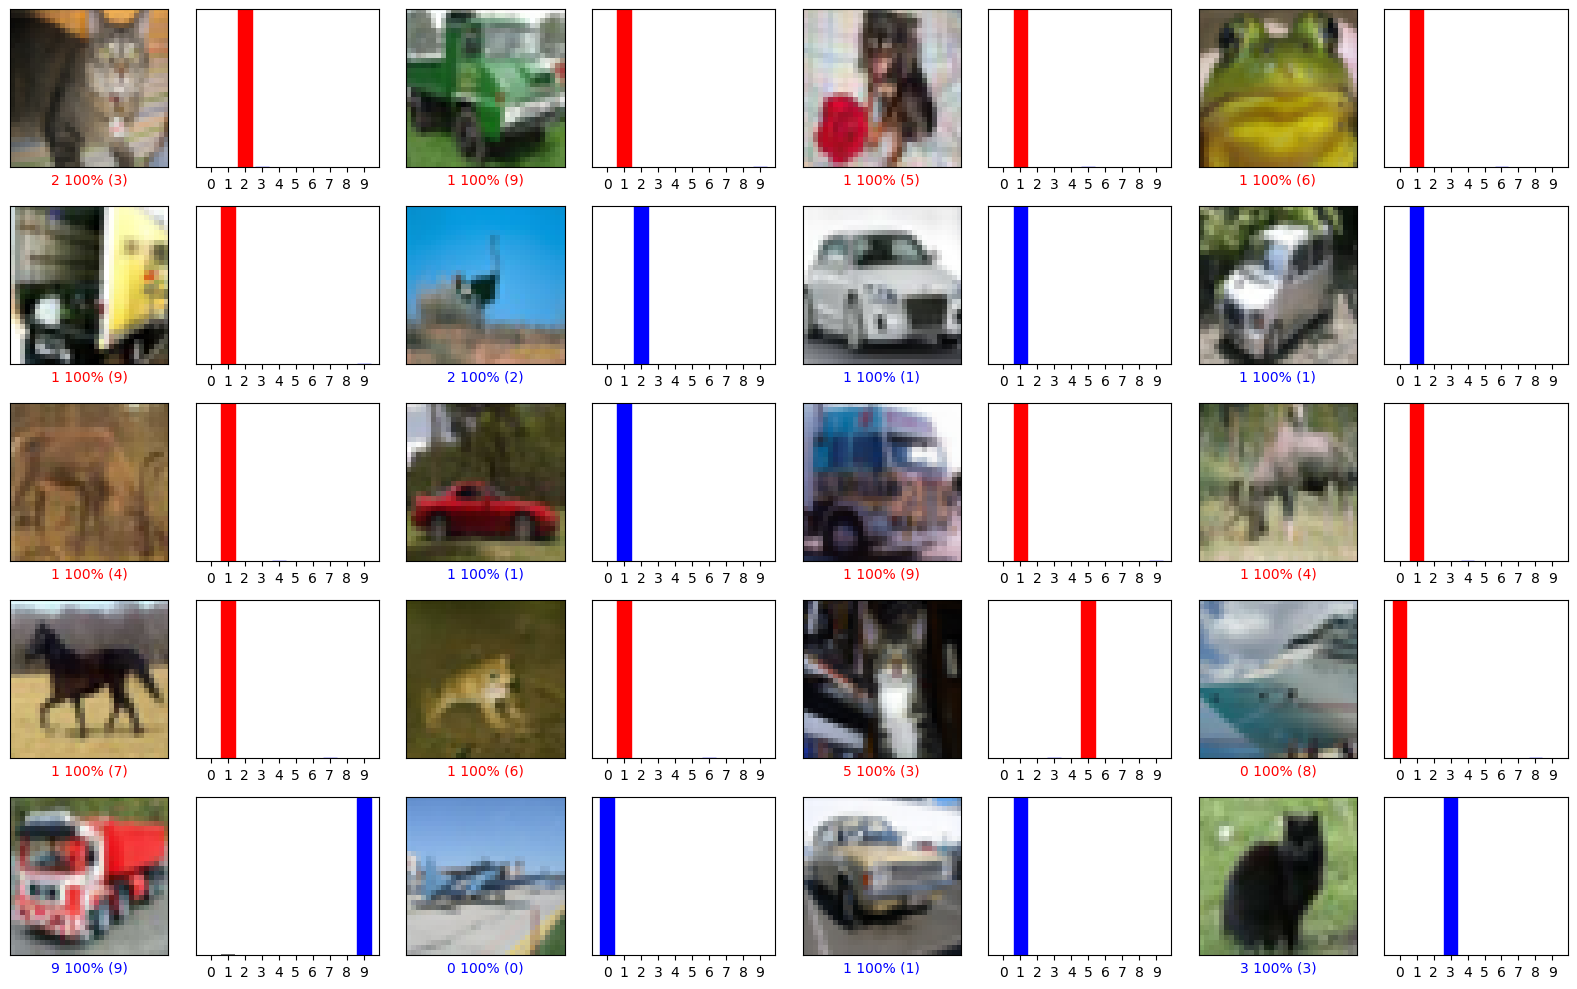

In [ ]:
i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1

num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+start, predictions[i+start], y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()

## 7. Guardamos el modelo para futuras evaluaciones

Id cambiando los nombres del archivo para ir guardando los diversos proyectos.
Aquí lo guardamos en "local", pero recordad que lo ideal es que lo guardeis en Google Drive (teneis que montar la unidad, fijar la ruta y allí guardar el modelo .h5)

In [ ]:
ruta_googledrive = "/content/drive/MyDrive/Entregables/Entregable_04-Deep_Learning/Models/" # A revisar en vuestra instancia

model.save(ruta_googledrive+'cifar10_model_03.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
